In [2]:
import jax
import jax.numpy as jnp

import specq_dev.specq.shared as specq
from specq_jax.core import rotating_duffling_oscillator_hamiltonian, signal_with_phase, signal, calculate_expvals, plot_expvals
from specq_dev.specq.qiskit import get_circuit, get_ibm_service_and_backend, IBMQDeviceProperties, transplie_circuits
from specq_jax.pulse import DragPulse, JaxBasedPulseSequence
import pennylane as qml

import matplotlib.pyplot as plt

In [3]:
def whitebox_v2(
    params: jnp.ndarray,
    t: jnp.ndarray,
    H: qml.pulse.parametrized_hamiltonian.ParametrizedHamiltonian,
    num_parameterized: int,
):
    # Evolve under the Hamiltonian
    unitary = qml.evolve(H)([params] * num_parameterized, t, return_intermediate=True)
    # Return the unitary
    return qml.matrix(unitary)


def get_simulator(
    qubit_info: specq.QubitInformationV3, t_eval: jnp.ndarray, phase: float = 0.0
):
    fixed_freq_signal = lambda params, t: signal(
        params,
        t,
        phase,
        qubit_info.frequency,
        t_eval[-1],
    )

    H = rotating_duffling_oscillator_hamiltonian(qubit_info, fixed_freq_signal)
    num_parameterized = len(H.coeffs_parametrized)

    simulator = lambda params: whitebox_v2(params, t_eval, H, num_parameterized)

    return simulator

In [4]:
def define_config_and_pulse_sequence():

    instance = "utokyo-kawasaki/keio-internal/keio-students"
    backend_name = "ibm_kawasaki"

    service, backend = get_ibm_service_and_backend(instance, backend_name)

    device_properties = IBMQDeviceProperties.from_backend(backend, qubit_indices=[0])

    qubit_info = device_properties.qubit_informations[0]

    dt = device_properties.dt

    total_length = 320

    amp = 0.25  # NOTE: Choice of amplitude is arbitrary
    area = (
        1 / (2 * qubit_info.drive_strength) / dt
    )  # NOTE: Choice of area is arbitrary e.g. pi pulse
    sigma = (1 * area) / (amp * jnp.sqrt(2 * jnp.pi))

    pulse_sequence = JaxBasedPulseSequence(
        pulses=[
            DragPulse(
                total_length=total_length,
                base_amp=amp,
                base_sigma=float(sigma),
                base_beta=1 / qubit_info.anharmonicity,
                total_amps=1,
                max_amp=0,
                min_amp=0,
                final_amp=1.0,
            )
        ],
        pulse_length_dt=total_length,
    )

    t_eval = jax.numpy.linspace(0, total_length * dt, 100)

    simulator = get_simulator(qubit_info=qubit_info, t_eval=t_eval)

    measurement_timings = jnp.arange(
        device_properties.min_length, total_length + 1, device_properties.granularity
    )

    key = jax.random.PRNGKey(0)
    params = pulse_sequence.sample_params(key)
    waveform = pulse_sequence.get_waveform(params)
    waveforms = [waveform[:t] for t in measurement_timings]

    exp_config = specq.ExperimentConfigV3(
        qubits=[qubit_info],
        expectation_values_order=specq.default_expectation_values,
        parameter_names=[],
        backend_name=backend.name,
        shots=3000,
        EXPERIMENT_IDENTIFIER="whitebox_test_0001",
        EXPERIMENT_TAGS=["whitebox_test", "DRAG"],
        description="Whitebox test with DRAG pulse",
        device_cycle_time_ns=device_properties.dt,
        sequence_duration_dt=total_length,
        instance=instance,
        sample_size=18 * len(measurement_timings),
        additional_info=dict(
            pulse_class="DragPulse",
            num_pulses=1,
        ),
    )

    return exp_config, pulse_sequence, service, backend, simulator, waveforms

In [5]:
exp_config, pulse_sequence, service, backend, simulator, waveforms = define_config_and_pulse_sequence()

In [12]:
total_length = 320
dt = 2 / 9
t_eval = jax.numpy.linspace(0, total_length * dt, 320)

device_properties = IBMQDeviceProperties.from_backend(backend, qubit_indices=[0])

simulator = get_simulator(
    qubit_info=device_properties.qubit_informations[0], t_eval=t_eval, phase=0
)

# fixed_freq_signal((waveform, 3 * jnp.pi / 4), t_eval)

/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


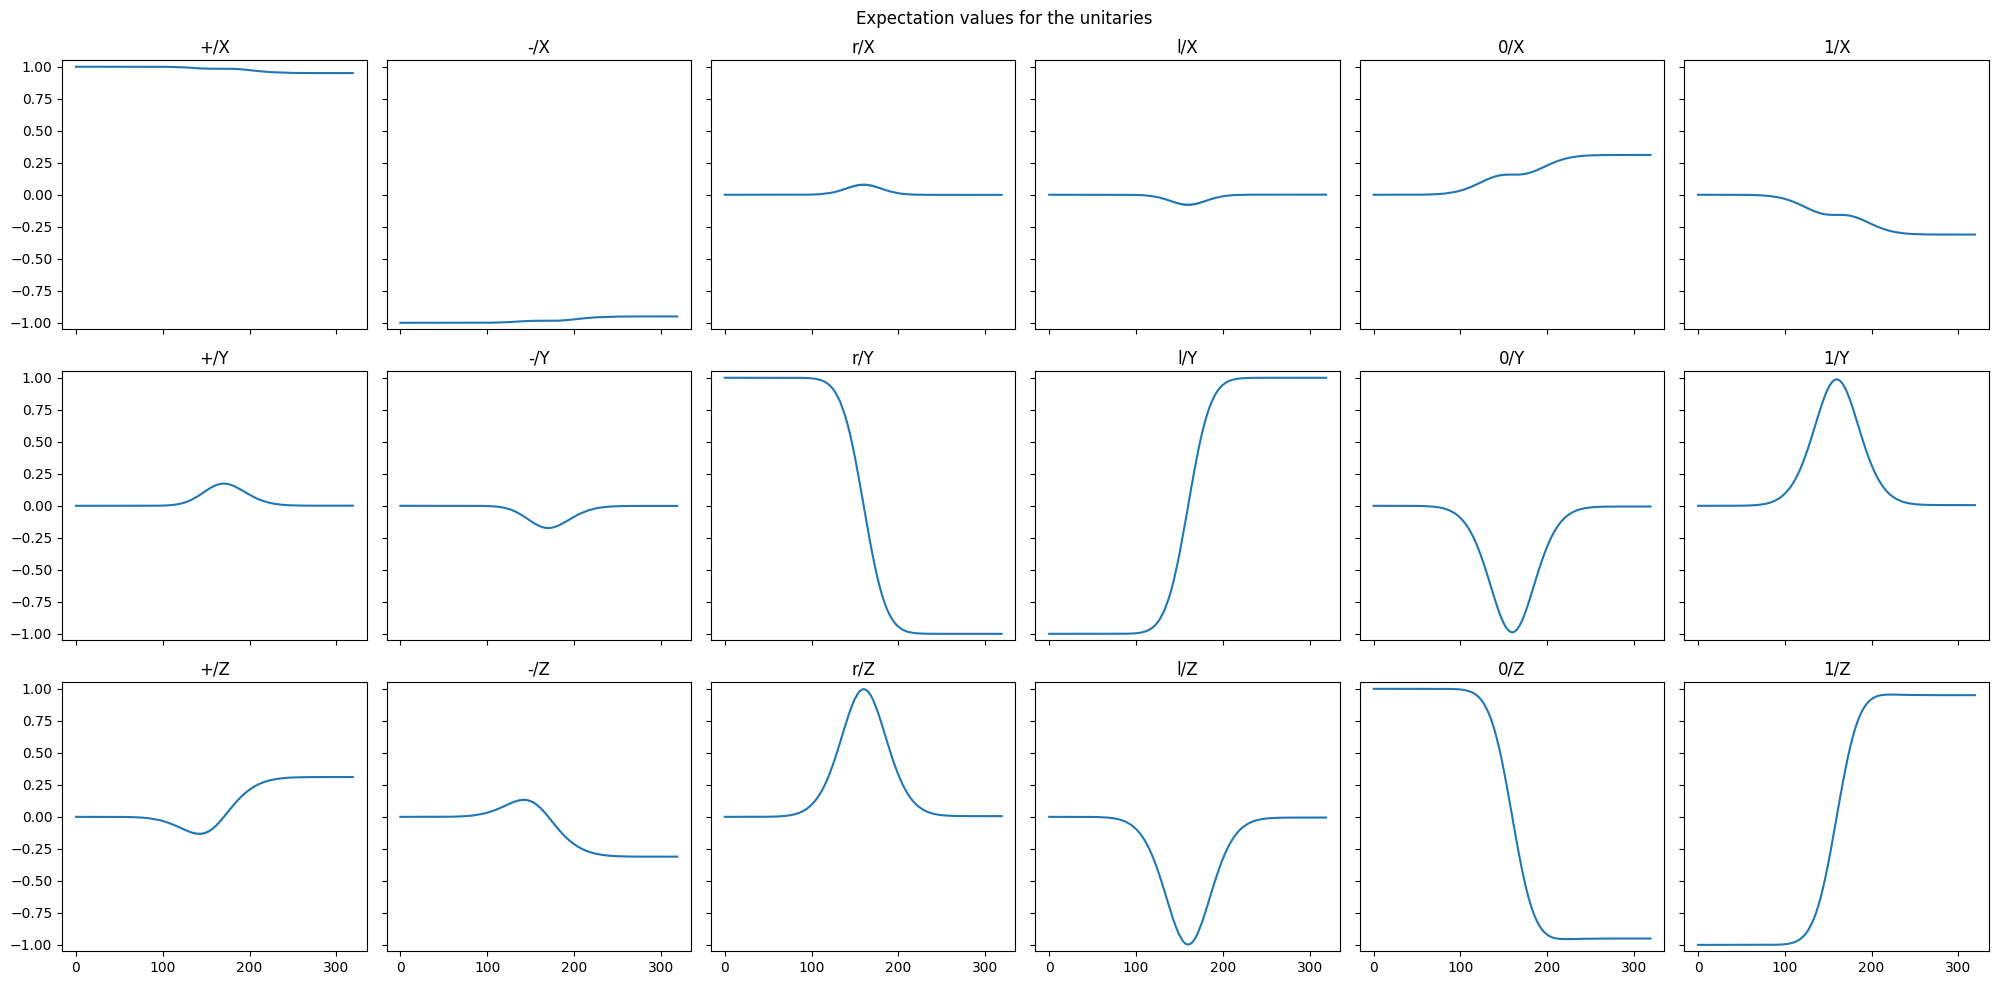

In [13]:
unitaries = simulator(waveforms[-1])
expvals = calculate_expvals(unitaries)
plot_expvals(expvals)